### Импорт библиотек 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns
import io
import re

### Загружаем датасет 

In [128]:
df = pd.read_csv('C:\\Users\\JOHANN MOULEO\\ML_Sys_Design_Project\\expanded_requests (1).csv', sep = ',')
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted


### Приводим целевую переменную к числовым данным

In [129]:
# Создаем колонку 'target': 1, если заказ принят ('Accepted'), иначе 0
df['target'] = (df['status'] == 'Accepted').astype(int)

In [130]:
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,target
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected,0
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected,0
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating,0
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating,0
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted,1


In [131]:
# Мы соединяем запрос клиента и наше предложение в одну строку для лучшего контекста
df['text_data'] = df['client_request'].fillna('') + " " + df['commercial_proposal'].fillna('')
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,target,text_data
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected,0,Need a quote for Backlink strategy by tomorrow...
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected,0,Need a quote for Keyword research by tomorrow....
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating,0,Can you help with Vector illustrations? We are...
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating,0,I need a Android bug fix for my tech startup. ...
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted,1,Need a quote for iOS MVP by tomorrow. Professi...


In [132]:
# Настройка преобразования колонок (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english'), 'text_data'),
        ('num', 'passthrough', ['budget_numeric'])
    ]
)

In [133]:
df.isnull().sum()

request_id             0
date                   0
sector                 0
client_request         0
commercial_proposal    0
budget_est             0
status                 0
target                 0
text_data              0
dtype: int64

In [104]:
df.describe()

,target
count,1000.000000
mean,0.347000
std,0.476254
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
# Функция для очистки и преобразования бюджета
def clean_budget(value):
    if pd.isna(value):
        return 0
    # Удаляем $ и берем первое числовое значение (float)
    match = re.search(r"(\d+(\.\d+)?)", str(value))
    if match:
        return float(match.group(1))
    return 0

In [ ]:
# Создаем числовую колонку для анализа
df['budget_numeric'] = df['budget_est'].apply(clean_budget)
# Создаем булеву колонку для переменной ставки
df['is_variable_rate'] = df['budget_est'].astype(str).str.contains('/word|/week', na=False)
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,target,text_data,budget_numeric,is_variable_rate
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected,0,Need a quote for Backlink strategy by tomorrow...,1460.0,False
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected,0,Need a quote for Keyword research by tomorrow....,3396.0,False
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating,0,Can you help with Vector illustrations? We are...,3737.0,False
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating,0,I need a Android bug fix for my tech startup. ...,4716.0,False
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted,1,Need a quote for iOS MVP by tomorrow. Professi...,1591.0,False


In [ ]:
# Создание Pipeline (Цепочка: Преобразование -> Модель)
# Базовая модель: Логистическая Регрессия
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

### Разделение данных на обучающую и тестовую выборки

In [137]:
X = df[['text_data', 'budget_numeric']]
y = df['target']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<Axes: >

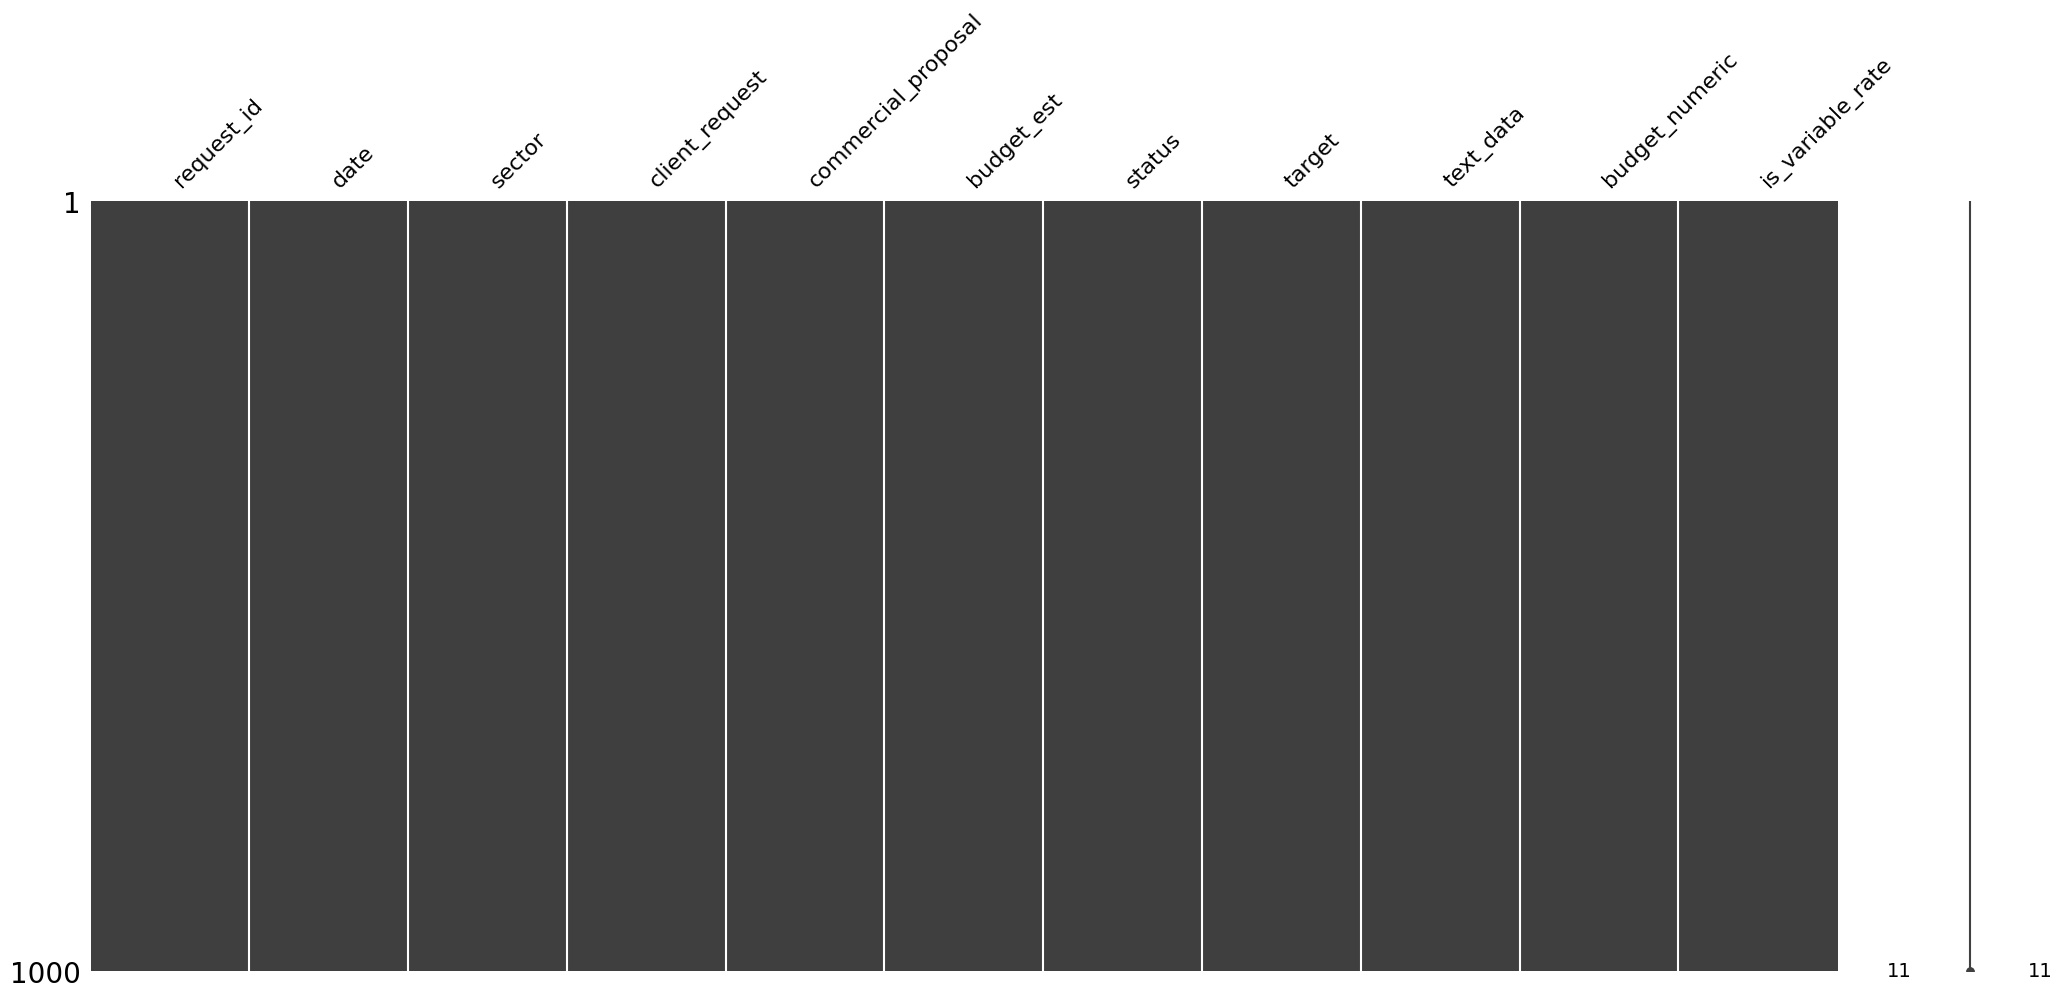

In [143]:
# Plotting 
import missingno as msno
msno.matrix(df)

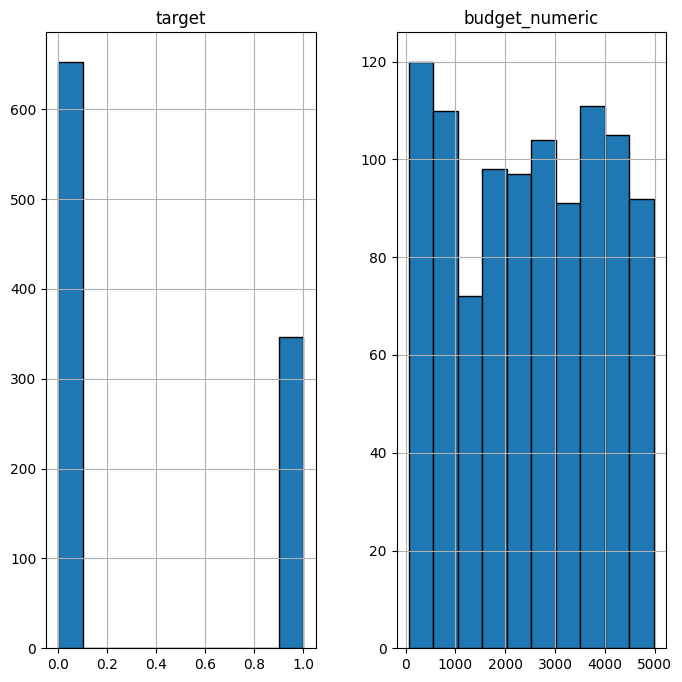

In [121]:
# Creating histograms
df.hist(figsize=(8,8), edgecolor = "black")
plt.show()

In [122]:
df["status"].value_counts()

status
Accepted       347
Negotiating    303
Rejected       209
Pending        141
Name: count, dtype: int64

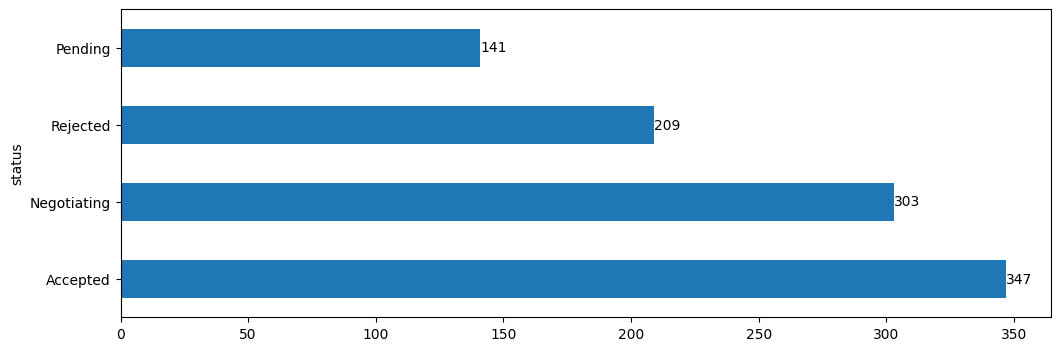

In [115]:
bar=df['status'].value_counts().plot.barh(figsize=(12,4))
bar=bar.bar_label(bar.containers[0], fontsize=10)

In [123]:
# Оцениваем пропуски
missing_values = df.isnull().sum()
print("\n=== Пропущенные значения ===")
print(missing_values[missing_values > 0])


=== Пропущенные значения ===
Series([], dtype: int64)


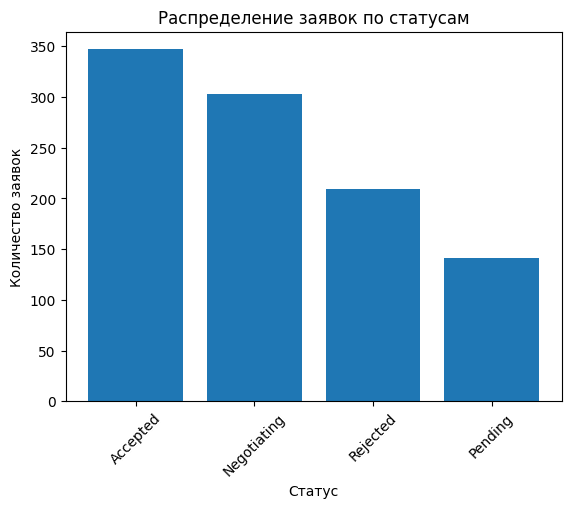

In [117]:
status_counts = df['status'].value_counts()

plt.figure()
plt.bar(status_counts.index, status_counts.values)
plt.title("Распределение заявок по статусам")
plt.xlabel("Статус")
plt.ylabel("Количество заявок")
plt.xticks(rotation=45)
plt.show()


<Figure size 640x480 with 0 Axes>

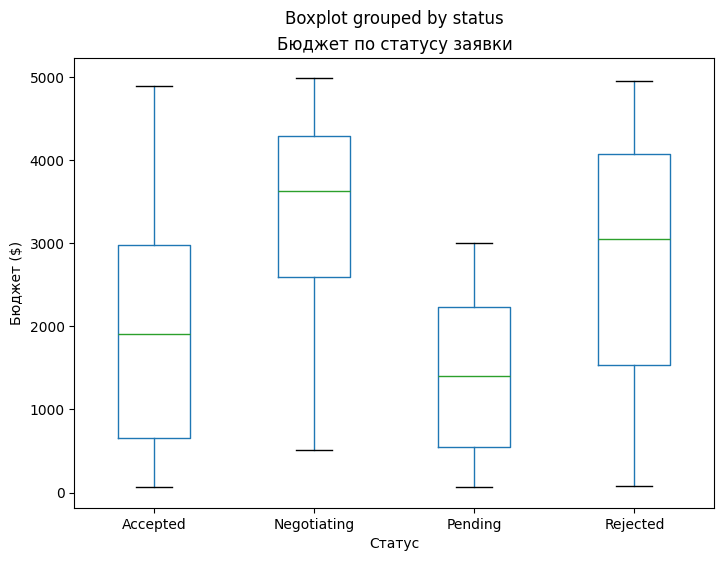

In [118]:
plt.figure()
boxplot = df.boxplot(column ='budget_numeric', by='status', grid=False, figsize=(8,6))
plt.title("Бюджет по статусу заявки")
plt.xlabel("Статус")
plt.ylabel("Бюджет ($)")

plt.show()

### Обучение и валидация моделей

In [139]:
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=['text_data', 'budget_numeric'])

if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=['text_data', 'budget_numeric'])

In [140]:
print("Запуск обучения Baseline модели...")
baseline_model.fit(X_train, y_train)

Запуск обучения Baseline модели...


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [141]:
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]
y_pred = baseline_model.predict(X_test)

In [142]:
from sklearn.metrics import classification_report
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\n Результат ROC-AUC: {auc_score:.2f}")
print("\nДетальный отчет по метрикам (Classification Report):")
print(classification_report(y_test, y_pred))


 Результат ROC-AUC: 0.63

Детальный отчет по метрикам (Classification Report):
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       131
           1       0.45      0.59      0.51        69

    accuracy                           0.60       200
   macro avg       0.59      0.60      0.59       200
weighted avg       0.64      0.60      0.61       200

